In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.io as io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体为支持中文的字体（可以根据实际情况选择不同的字体）
rcParams['font.family'] = 'SimHei'  # SimHei 是黑体字体
rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题

In [2]:
# 自定义数据集类
class SpectralDataset(Dataset):
    def __init__(self, encoded_data, original_spectra):
        self.encoded_data = encoded_data
        self.original_spectra = original_spectra
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, idx):
        return self.encoded_data[idx], self.original_spectra[idx]

In [3]:
# 数据加载函数
def load_data(mat_file_encoded, mat_file_original):
    # 加载MAT文件
    mat_encoded = io.loadmat(mat_file_encoded)
    mat_original = io.loadmat(mat_file_original)
    
    # 提取数据
    encoded_data = mat_encoded['sample']        # 确保 'sample' 是编码后的光强响应数据（B）
    original_spectra = mat_original['G_matrix'] # 确保 'G_matrix' 是原始光谱数据（A）
    
    return encoded_data, original_spectra

In [4]:
# 数据预处理函数
def preprocess_data(original_spectra, encoded_data):
    # 转换为numpy数组
    A = np.array(original_spectra)
    B = np.array(encoded_data)
    
    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(B, A, test_size=0.2, random_state=42)
    
    # 标准化
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)
    
    y_train = scaler_y.fit_transform(y_train)
    y_test = scaler_y.transform(y_test)
    
    # 转换为torch张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

In [5]:
# 数据增强函数（可选）
def augment_data(original_spectra, encoded_data, num_augment=500):
    augmented_A = []
    augmented_B = []
    for _ in range(num_augment):
        idx = np.random.randint(0, len(original_spectra))
        shift_A = np.random.uniform(-0.05, 0.05, size=original_spectra.shape[1])
        shift_B = np.random.uniform(-0.05, 0.05, size=encoded_data.shape[1])
        scale_A = np.random.uniform(0.95, 1.05, size=original_spectra.shape[1])
        scale_B = np.random.uniform(0.95, 1.05, size=encoded_data.shape[1])
        noise_A = np.random.normal(0, 0.01, size=original_spectra.shape[1])
        noise_B = np.random.normal(0, 0.01, size=encoded_data.shape[1])
        
        augmented_spectrum = original_spectra[idx] * scale_A + noise_A + shift_A
        augmented_measurement = encoded_data[idx] * scale_B + noise_B + shift_B  # 根据实际情况调整
        
        augmented_A.append(augmented_spectrum)
        augmented_B.append(augmented_measurement)
    
    return np.array(augmented_A), np.array(augmented_B)

In [6]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [7]:
# 定义Transformer块，（看不懂）
class TransformerBlock(nn.Module):
    def __init__(self, channels, heads=2, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=channels, num_heads=heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(channels)
        self.dropout1 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(channels, channels * 4),
            nn.ReLU(inplace=True),
            nn.Linear(channels * 4, channels),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(channels)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x):
        # x: (batch_size, channels, seq_length)
        x = x.permute(2, 0, 1)  # (seq_length, batch_size, channels)
        attn_output, _ = self.attention(x, x, x)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        x = x.permute(1, 2, 0)  # (batch_size, channels, seq_length)
        return x

In [8]:
class EnhancedResCNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_channels=128, num_residuals=6, heads=4, dropout=0.1):
        super(EnhancedResCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_channels)
        self.bn_fc1 = nn.BatchNorm1d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_channels)
        
        # 堆叠残差块和Transformer块
        layers = []
        for _ in range(num_residuals):
            layers.append(ResidualBlock(num_channels, dropout=dropout))
            layers.append(TransformerBlock(num_channels, heads=heads, dropout=dropout))
        self.layers = nn.Sequential(*layers)
        
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(num_channels, output_dim)
    
    def forward(self, x):
        # x: (batch_size, input_dim)
        out = self.fc1(x)  # (batch_size, num_channels)
        out = self.bn_fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = out.unsqueeze(2)  # (batch_size, num_channels, 1)
        out = self.conv1(out)   # (batch_size, num_channels, 1)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.layers(out)  # (batch_size, num_channels, 1)
        
        out = self.conv2(out)   # (batch_size, num_channels, 1)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out = out.squeeze(2)    # (batch_size, num_channels)
        out = self.fc2(out)     # (batch_size, output_dim)
        return out

In [17]:
# 定义训练函数（记录损失）
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, num_epochs=100, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        current_lr = scheduler.get_last_lr()
        print("Current Learning Rate:", current_lr)
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_running_loss += loss.item() * inputs.size(0)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.6f}, Val Loss: {val_loss:.6f}')
        
        # 调整学习率
        scheduler.step(val_loss)
        
        # 早停法检查
        early_stopping(val_loss, model, 'best_enhanced_rescnn_model.pth')
        if early_stopping.early_stop:
            print("提前停止")
            break
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_enhanced_rescnn_model.pth')
            print('保存最佳模型')
    
    print('训练完成')
    return train_losses, val_losses

In [10]:
# 权重初始化函数
def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [11]:
# 定义早停法类
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

Current Learning Rate: [0.001]
Epoch 1/200, Train Loss: 0.833277, Val Loss: 0.730220
Validation loss decreased (inf --> 0.730220).  Saving model ...
保存最佳模型
Current Learning Rate: [0.001]
Epoch 2/200, Train Loss: 0.754942, Val Loss: 0.631226
Validation loss decreased (0.730220 --> 0.631226).  Saving model ...
保存最佳模型
Current Learning Rate: [0.001]
Epoch 3/200, Train Loss: 0.668653, Val Loss: 0.730417
EarlyStopping counter: 1 out of 20
Current Learning Rate: [0.001]
Epoch 4/200, Train Loss: 0.629267, Val Loss: 0.532828
Validation loss decreased (0.631226 --> 0.532828).  Saving model ...
保存最佳模型
Current Learning Rate: [0.001]
Epoch 5/200, Train Loss: 0.603973, Val Loss: 0.442833
Validation loss decreased (0.532828 --> 0.442833).  Saving model ...
保存最佳模型
Current Learning Rate: [0.001]
Epoch 6/200, Train Loss: 0.555942, Val Loss: 0.463935
EarlyStopping counter: 1 out of 20
Current Learning Rate: [0.001]
Epoch 7/200, Train Loss: 0.542055, Val Loss: 0.452001
EarlyStopping counter: 2 out of 20
C

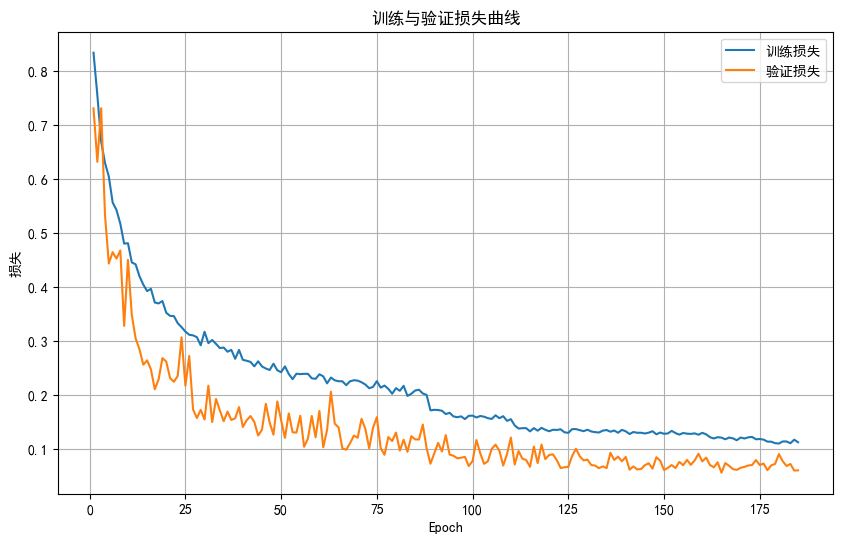

In [22]:
# 主脚本
if __name__ == "__main__":
    # 加载数据
    mat_file_encoded = 'sample.mat'    # 编码后的光强响应数据文件（B）
    mat_file_original = 'G_matrix.mat' # 原始光谱数据文件（A）
    
    encoded_data, original_spectra = load_data(mat_file_encoded, mat_file_original)
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data(original_spectra, encoded_data)
    
    # 数据增强（可选）
    A_aug, B_aug = augment_data(original_spectra, encoded_data, num_augment=500)
    
   # # 合并原始数据和增强数据
    A_combined = np.vstack((original_spectra, A_aug))
    B_combined = np.vstack((encoded_data, B_aug))
    
    # 重新预处理数据
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = preprocess_data(A_combined, B_combined)
    
    # 创建数据加载器
    batch_size = 32
    train_dataset = SpectralDataset(X_train, y_train)
    val_dataset = SpectralDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # 模型初始化
    input_dim = B_combined.shape[1]  # units数，例如90
    output_dim = A_combined.shape[1]  # wavelengths数，例如40
    model = EnhancedResCNN(input_dim=input_dim, output_dim=output_dim, 
                           num_channels=128, num_residuals=6, heads=4, dropout=0.1)
    
    # 权重初始化
    #model.apply(weights_init)
    
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    # 学习率调度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    
    # 早停法实例
    early_stopping = EarlyStopping(patience=20, verbose=True)
    
    # 训练模型并记录损失
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, 
                                         scheduler, early_stopping, num_epochs=200, device=device)
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='训练损失')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='验证损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失')
    plt.title('训练与验证损失曲线')
    plt.legend()
    plt.grid(True)
    plt.show()

验证集 MAE: 0.011912, MSE: 0.001218, R²: 0.944587


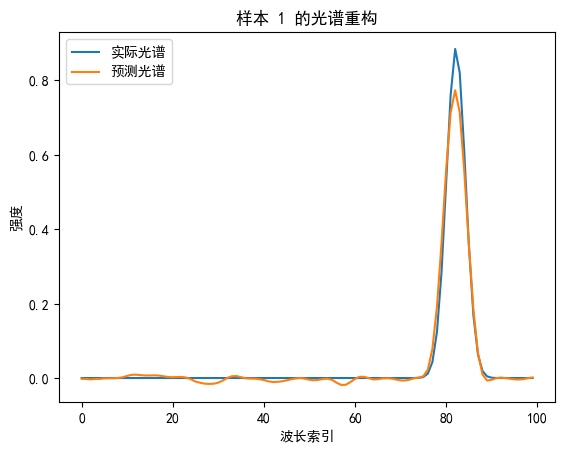

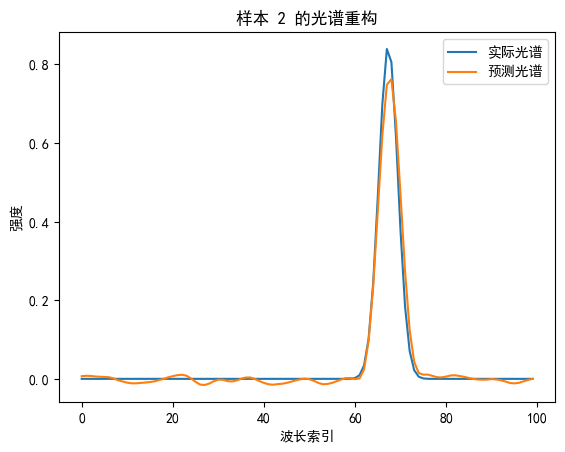

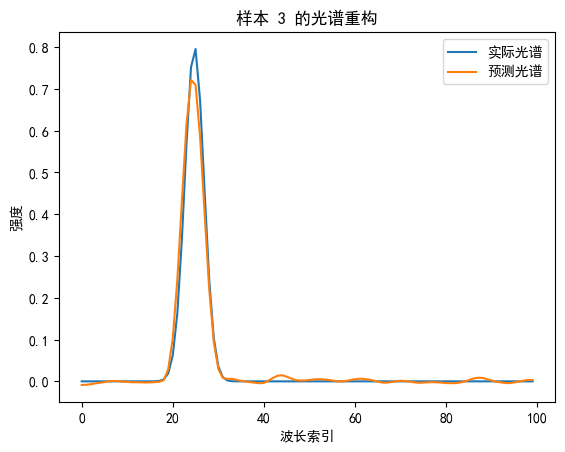

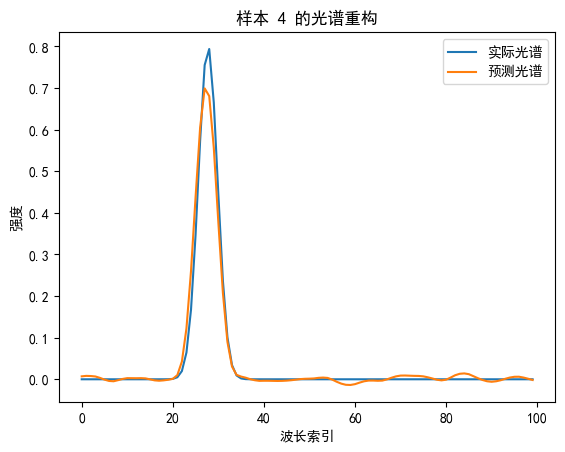

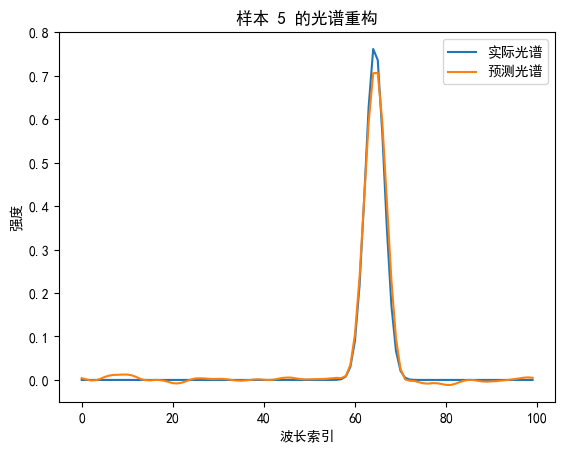

In [23]:
# 主脚本
if __name__ == "__main__":
#####################################################
    # 加载最佳模型
    best_model = EnhancedResCNN(input_dim=input_dim, output_dim=output_dim, 
                                num_channels=128, num_residuals=6, heads=4, dropout=0.1)
    best_model.load_state_dict(torch.load('best_enhanced_rescnn_model.pth'))
    best_model.to(device)
    best_model.eval()
    
    # 验证集上的预测
    with torch.no_grad():
        predictions = []
        actuals = []
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            outputs = best_model(inputs)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.numpy())
    
        predictions = np.concatenate(predictions, axis=0)
        actuals = np.concatenate(actuals, axis=0)
    
    # 反标准化
    predictions = scaler_y.inverse_transform(predictions)
    actuals = scaler_y.inverse_transform(actuals)
    
    # 计算均方误差（MSE）、平均绝对误差（MAE）和决定系数（R²）
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    print(f'验证集 MAE: {mae:.6f}, MSE: {mse:.6f}, R²: {r2:.6f}')
    
    # 可视化部分样本的预测结果
    num_samples_to_plot = min(5, len(predictions))
    for i in range(num_samples_to_plot):
        plt.figure()
        plt.plot(actuals[i], label='实际光谱')
        plt.plot(predictions[i], label='预测光谱')
        plt.xlabel('波长索引')
        plt.ylabel('强度')
        plt.title(f'样本 {i+1} 的光谱重构')
        plt.legend()
        plt.show()